In [1]:
import os
import re
from pathlib import Path
import time
import tqdm

import numpy as np
import pandas as pd 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
#Importing image dataset into pytorch tensors
transform = transforms.ToTensor()

#To download the dataset set download=True parameter
train_data = datasets.MNIST(root='./Data', train=True, transform=transform)
test_data = datasets.MNIST(root='./Data', train=False, transform=transform)

torch.Size([1, 28, 28])


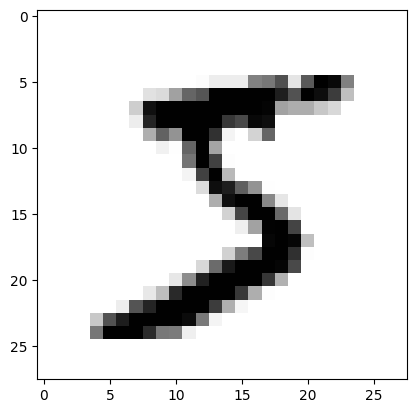

In [3]:
#Format of an image
image, label = train_data[0]
print(image.shape)
plt.imshow(image.reshape((28,28)), cmap='gist_yarg')

In [4]:
#Loading batches of images with Torch Dataloaer 

torch.manual_seed(101)

train_batch_size = 100
test_batch_size = 500

train_data_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

Number of images per batch 100 -> Shape torch.Size([1, 28, 28]) 
Number of labels 100


Print the first 12 images and labels
 Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]



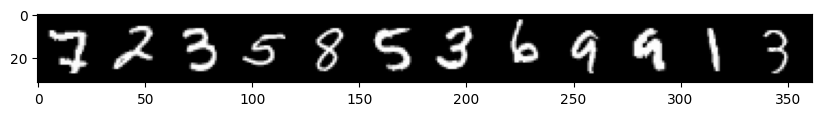

In [5]:
#Printing part of the dataset for better visualize it

from torchvision.utils import make_grid

np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

for images, labels in train_data_loader:
    break

images_number = images.shape[0]
images_size = images.shape[1:]
labels_number = labels.shape[0]

print(f'Number of images per batch {images_number} -> Shape {images_size} \nNumber of labels {labels_number}\n\n')


#Printing the first 12 images and correspondi labels

img = make_grid(images[:12], nrow=12)
plt.figure(figsize=(10,4))

print("Print the first 12 images and labels\n Labels: ", labels[:12].numpy())
plt.imshow(np.transpose(img.numpy(), (1,2,0)),  cmap='gist_yarg')

print()

In [6]:
#Defining multilayer perceptron model

class MLPerceptron(nn.Module):

    def __init__(self, input_size, output_size, layers=[120,84]): 
        
        #Creating three fully connected layers

        super().__init__()

        self.fc1 = nn.Linear(in_features=input_size, out_features=layers[0])
        self.fc2 = nn.Linear(in_features=layers[0], out_features=layers[1])
        self.fc3 = nn.Linear(in_features=layers[1], out_features=output_size)

    def forward(self, X):
        #Defining foward method with ReLU

        X = torch.nn.functional.relu(self.fc1(X))
        X = torch.nn.functional.relu(self.fc2(X))
        X = torch.nn.functional.log_softmax(X, dim=1) #For multiclass classification

        return X

#Initialing model
torch.manual_seed(101)
model = MLPerceptron(input_size=(28*28*1), output_size=10) ##Input size is the flatten image size (28*28*1) and the output size is the number of labels (0,9) = 10

#Print model configuration
print(f"\tModule name\t | \tParameters Listed")
for name, parameter in model.named_parameters():
    print(f'\t {name} \t | \t {parameter.numel()}')


#Defining loss function and optmizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


	Module name	 | 	Parameters Listed
	 fc1.weight 	 | 	 94080
	 fc1.bias 	 | 	 120
	 fc2.weight 	 | 	 10080
	 fc2.bias 	 | 	 84
	 fc3.weight 	 | 	 840
	 fc3.bias 	 | 	 10


In [7]:
###Training the ANN model

start_time = time.time() #To compute total training time

epochs_number = 10

#Variables for tracking training and test metrics 
train_wrongs = []
train_rights = []
test_wrongs = []
test_rights = []

for epoch in range(epochs_number): 
    
    train_correct=0
    test_correct=0

    #Running each batch from data loader into the model
    for batch, (X_train, y_train) in enumerate(train_data_loader, start=1):

        y_pred = model(X_train.view(train_batch_size,-1))                       #The ANN expects a single dimension tensor as input data, creating 100 images with one dimension 
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]                                #Focus on the output neuron with the hightes probablity
        batch_correct = (predicted == y_train).sum()                            #Number of corrected predictions per batch
        train_correct += batch_correct                                          #Correct predictions per epoch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Tracking batch accuracy
        if batch%200 == 0:
            accuracy = train_correct.item()*100/(100*batch)
            print(f" Epoch: {epoch} \t | \t Batch: {batch} \t | \t Loss: {round(loss.item(),4)} \t | \t Accuracy: {round(accuracy, 6)}")


    train_wrongs.append(loss.item())
    train_rights.append(train_correct)


    #Here we can pass the test data into the epoch without the optimizer to check the evolution of ANN learning
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_data_loader):

            y_val = model(X_test.view(test_batch_size, -1))                     #The ANN expects a single dimension tensor as input data, creating 500 images with one dimension

            predicted = torch.max(y_val.data,1)[1]
            test_correct += (predicted==y_test).sum()


    loss = criterion(y_val, y_test)
    test_wrongs.append(loss.item())
    test_rights.append(test_correct)

        

training_time = time.time() - start_time
print(f"Training duration: {training_time/60} mins")

 Epoch: 0 	 | 	 Batch: 200 	 | 	 Loss: 0.3118 	 | 	 Accuracy: 73.635
 Epoch: 0 	 | 	 Batch: 400 	 | 	 Loss: 0.3745 	 | 	 Accuracy: 82.28
 Epoch: 0 	 | 	 Batch: 600 	 | 	 Loss: 0.1613 	 | 	 Accuracy: 85.716667
 Epoch: 1 	 | 	 Batch: 200 	 | 	 Loss: 0.2972 	 | 	 Accuracy: 93.785
 Epoch: 1 	 | 	 Batch: 400 	 | 	 Loss: 0.1351 	 | 	 Accuracy: 94.0
 Epoch: 1 	 | 	 Batch: 600 	 | 	 Loss: 0.1241 	 | 	 Accuracy: 94.323333
 Epoch: 2 	 | 	 Batch: 200 	 | 	 Loss: 0.1534 	 | 	 Accuracy: 95.465
 Epoch: 2 	 | 	 Batch: 400 	 | 	 Loss: 0.0703 	 | 	 Accuracy: 95.5825
 Epoch: 2 	 | 	 Batch: 600 	 | 	 Loss: 0.1048 	 | 	 Accuracy: 95.656667
 Epoch: 3 	 | 	 Batch: 200 	 | 	 Loss: 0.1675 	 | 	 Accuracy: 96.615
 Epoch: 3 	 | 	 Batch: 400 	 | 	 Loss: 0.1119 	 | 	 Accuracy: 96.5125
 Epoch: 3 	 | 	 Batch: 600 	 | 	 Loss: 0.0565 	 | 	 Accuracy: 96.623333
 Epoch: 4 	 | 	 Batch: 200 	 | 	 Loss: 0.1467 	 | 	 Accuracy: 97.36
 Epoch: 4 	 | 	 Batch: 400 	 | 	 Loss: 0.072 	 | 	 Accuracy: 97.1975
 Epoch: 4 	 | 	 Batch: 6

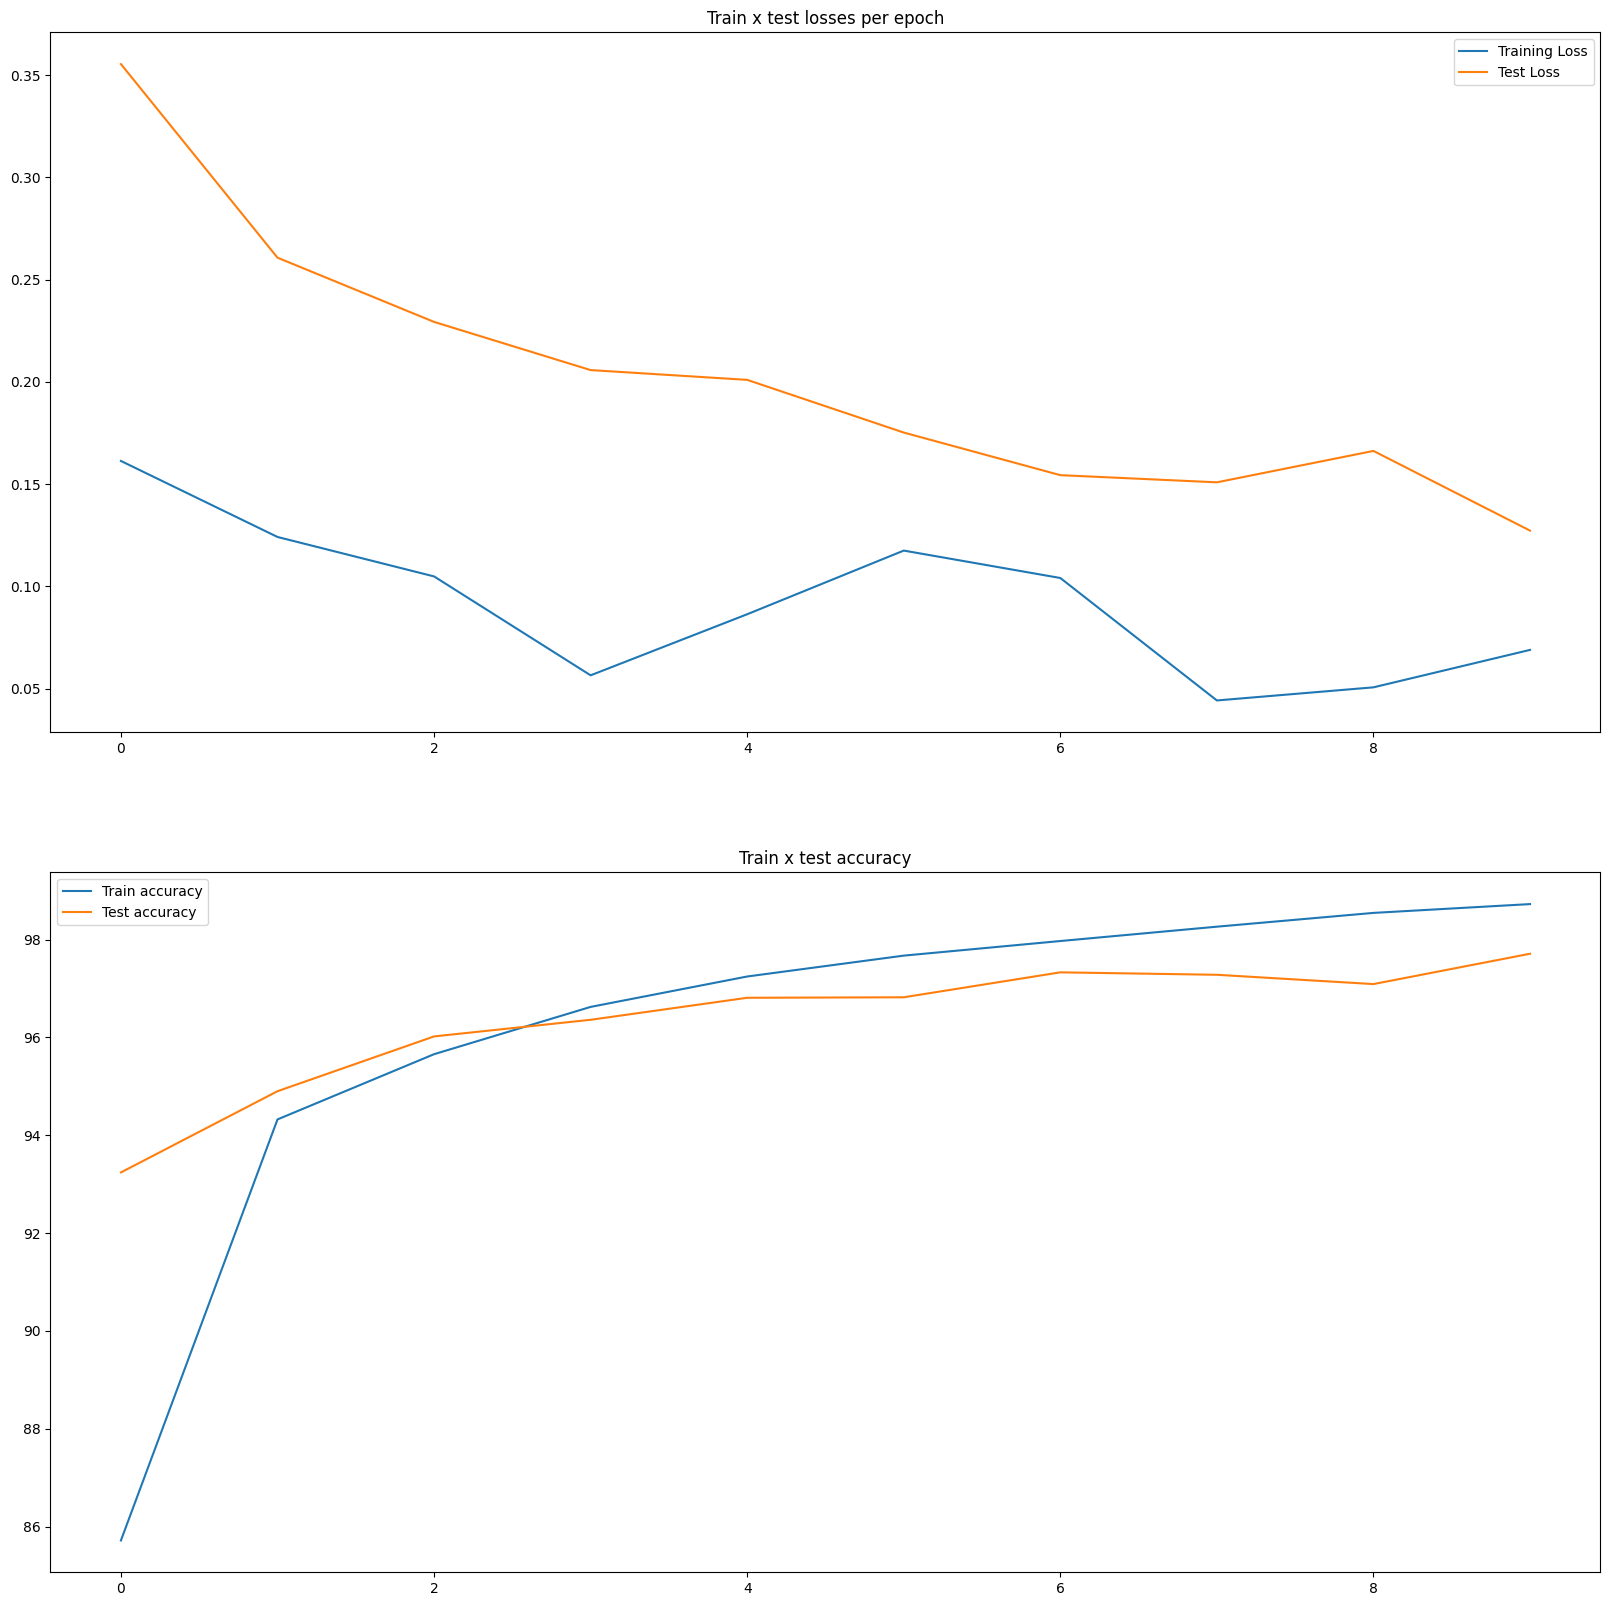

In [8]:
#Plotting train evalutaion through epochs

figure = plt.figure(figsize=(20,20))

#Plotting evolution of losses per epoch
figure.add_subplot(211)
plt.plot(train_wrongs, label='Training Loss')
plt.plot(test_wrongs, label='Test Loss')
plt.title("Train x test losses per epoch")
plt.legend()

#Plot the accuracy for train and test
figure.add_subplot(212)
train_acc = [t/600 for t in train_rights]
test_acc = [t/100 for t in test_rights]
plt.plot(train_acc, label="Train accuracy")
plt.plot(test_acc, label="Test accuracy")
plt.title("Train x test accuracy")
plt.legend()

In [9]:
#Testing validation set into trained ANN model

validation_data_loader = DataLoader(test_data, batch_size=5000, shuffle=False)

#use torch.no_grad() so it don't change weight and bias
with torch.no_grad():
    correct = 0

    for X_val, y_val in validation_data_loader:
        y_pred = model(X_val.view(len(X_val), -1))
        predicted = torch.max(y_pred,1)[1]
        correct+=(predicted==y_val).sum()

validation_accuracy = correct.item()/len(test_data)
print(f"Validation accuracy -> {validation_accuracy*100}")


#Plotting confusion matrix for the 10 labels
confusion_matrix = confusion_matrix(predicted.view(-1), y_val.view(-1))
print(f"-----------Confusion Matrix-----------\n {confusion_matrix}")

Validation accuracy -> 97.71
-----------Confusion Matrix-----------
 [[ 515    0    1    0    1    1    0    0    0    1]
 [   0  559    0    0    0    0    0    1    0    0]
 [   0    0  491    1    0    0    1    4    1    0]
 [   0    0    2  500    0    2    1    1    1    2]
 [   1    0    0    1  476    0    1    0    1    2]
 [   1    1    0    1    0  427    1    0    1    1]
 [   1    2    3    0    0    3  492    0    1    0]
 [   1    0    1    1    1    0    0  508    0    2]
 [   1    2    4    2    1    2    0    0  479    0]
 [   0    0    0    4    3    1    0    2    1  481]]
